In [1]:
# ensure classes imported from .py files are dynamically updated
%load_ext autoreload
%autoreload 2

# plot matplots nicely
%matplotlib inline  

In [2]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xeofs as xe
import xesmf as xes
import cmocean

# load pre-built data classes
from steric_height import StericHeight
from plotting_fns import PlottingFns as pfns
from utils import Utils as utls
from data_handler import *


pfns = pfns()

In [3]:
dot_ds = DOT().ds
lwe_ds = GRACE().ds
msl_ds = ERA5().ds

sha = StericHeight(ssh_ref='DOT',
                   ssh=dot_ds.dot,
                   lwe=lwe_ds.lwe_thickness,
                   msl=msl_ds.msl
                  ).get_sha()

gpha = GPHA()

In [4]:
elevation = GEBCO().ds.elevation

In [5]:
#fit the model
# https://xeofs.readthedocs.io/en/latest/content/user_guide/auto_examples/1single/plot_eeof.html
modes = 3

model = xe.single.EOF(use_coslat=True, n_modes=modes)

model.fit(sha.sha, dim="time")

evr = model.explained_variance_ratio()

components = model.components() # eofs, [mode, lat, lon]

scores = model.scores() #pcas, [time, mode]


In [6]:
#get sea ice
sice = xr.open_dataset('../Research/data/PROCESSED/nsidc_sea_ice.nc').nsidc_nt_seaice_conc_monthly
regridder = xes.Regridder(sice,elevation,'bilinear')
sice = regridder(sice)
sic_cmt = sice.groupby('time.month').mean()

/nfs/b0133/eejco/miniconda3/envs/sha-env/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [7]:
def plot_ice_and_isobath(ax,piz=False):
    if piz:
        data=sice.quantile(0.05,dim='time')
    else:
        data=sic_cmt.isel(month=8)
    ax.contour(sice.longitude.values,sice.latitude.values,data.values,transform=ccrs.PlateCarree(),levels=[0.15],cmap='binary',linewidths=2,vmin=0,vmax=5)
    ax.contour(elevation.longitude.values,elevation.latitude.values,elevation.values,transform=ccrs.PlateCarree(),levels=[-1000],cmap='BrBG',linewidths=2,linestyles=':',vmin=0,vmax=5)
 


In [16]:
def plot_mode_ts(ax,mode):
    ax.plot(scores.time,scores.sel(mode=mode))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.spines['bottom'].set_position('zero')

    ax.set_ylabel('Mode '+str(mode))
    ax.set_ylim([-250,250])

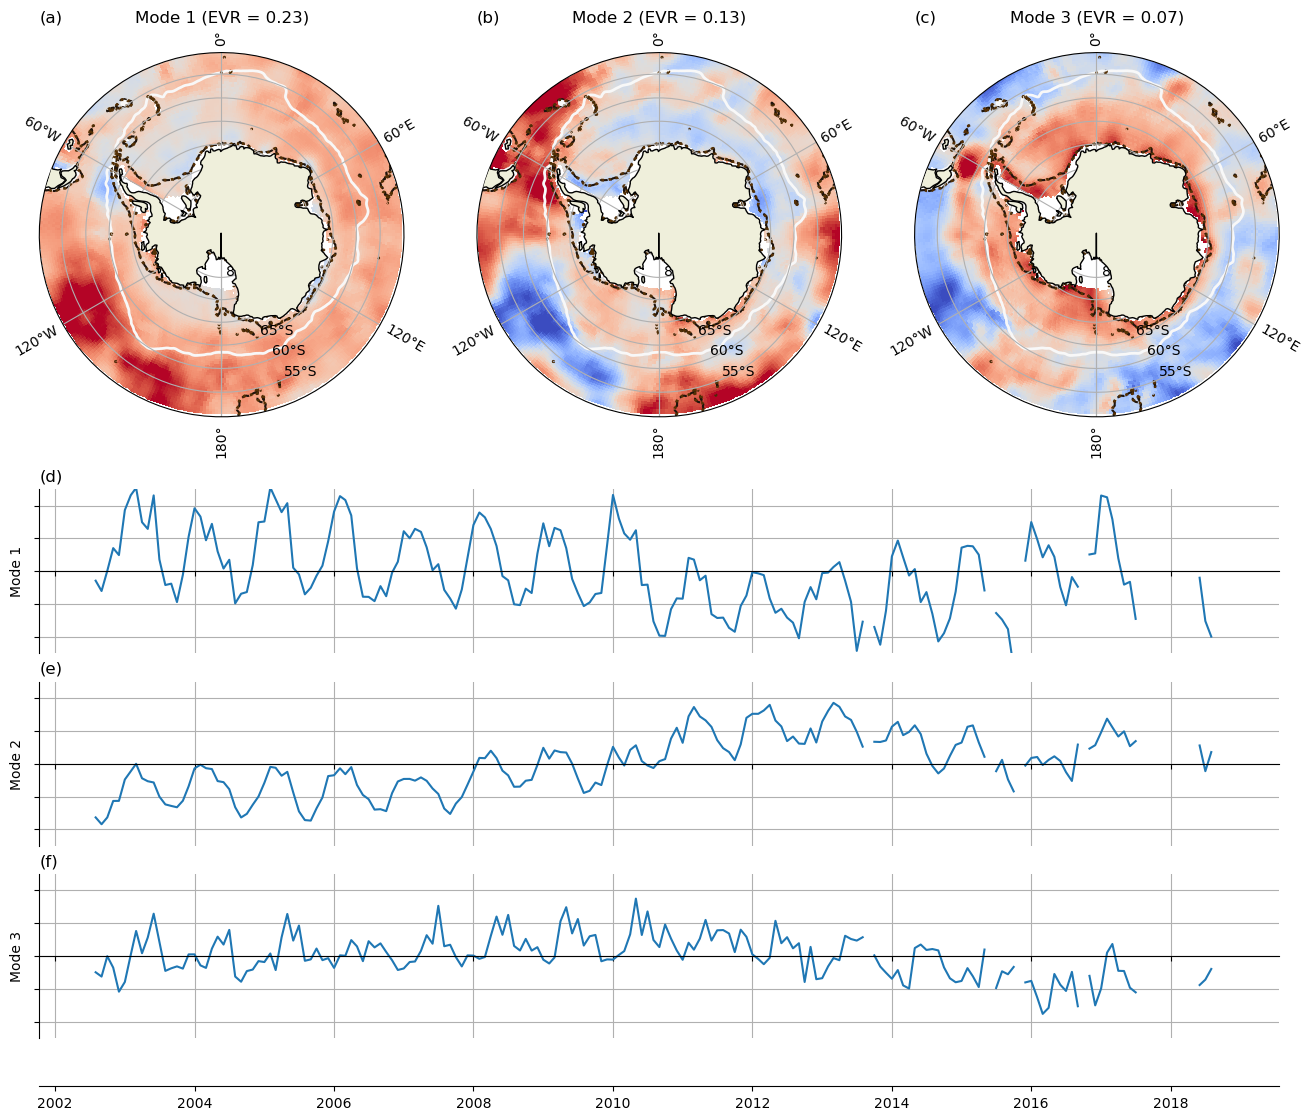

In [18]:
fig = plt.figure(figsize=(16,14))
axs=[]

gs = fig.add_gridspec(45,3)#,height_ratios=[1,2])

axs.append(fig.add_subplot(gs[0:19, 0],projection=ccrs.SouthPolarStereo()))
axs.append(fig.add_subplot(gs[0:19, 1],projection=ccrs.SouthPolarStereo()))
axs.append(fig.add_subplot(gs[0:19, 2],projection=ccrs.SouthPolarStereo()))

axs.append(fig.add_subplot(gs[20:27, 0:3]))
axs.append(fig.add_subplot(gs[28:35, 0:3]))
axs.append(fig.add_subplot(gs[36:43, 0:3]))
axs.append(fig.add_subplot(gs[44, 0:3]))

# plot maps
for n in list(range(modes)):
    m = n+1
    pfns.sp(axs[n],components.sel(mode=m),title='Mode {} (EVR = {})'.format(m,round(evr[n].item(),2)),vmax=0.02,cmap='coolwarm', bathy=elevation)
    plot_ice_and_isobath(axs[n])

axs[0].set_title('(a)',loc='left')
axs[1].set_title('(b)',loc='left')
axs[2].set_title('(c)',loc='left')

#plot timeseries
for n in list(range(modes)):
    plot_mode_ts(axs[n+3],n+1)

axs[3].set_title('(d)',loc='left')
axs[4].set_title('(e)',loc='left')
axs[5].set_title('(f)',loc='left')

#plot time
axs[6].plot(scores.time,scores.sel(mode=2),alpha=0)
axs[6].spines['left'].set_visible(False)
axs[6].yaxis.set_visible(False)
axs[6].spines['top'].set_visible(False)
axs[6].spines['right'].set_visible(False)



plt.tight_layout()



In [ ]:
fig,axs = plt.subplots(1,modes,figsize=(14,5),subplot_kw={'projection': ccrs.SouthPolarStereo()})

for n in list(range(modes)):
    m = n+1
    pfns.sp(axs[n],components.sel(mode=m),title='Mode {} (EVR = {})'.format(m,round(evr[n].item(),2)),vmax=0.02,cmap='coolwarm', bathy=elevation)
    plot_ice_and_isobath(axs[n])

axs[0].set_title('(a)',loc='left')
axs[1].set_title('(b)',loc='left')
axs[2].set_title('(c)',loc='left')

plt.tight_layout()


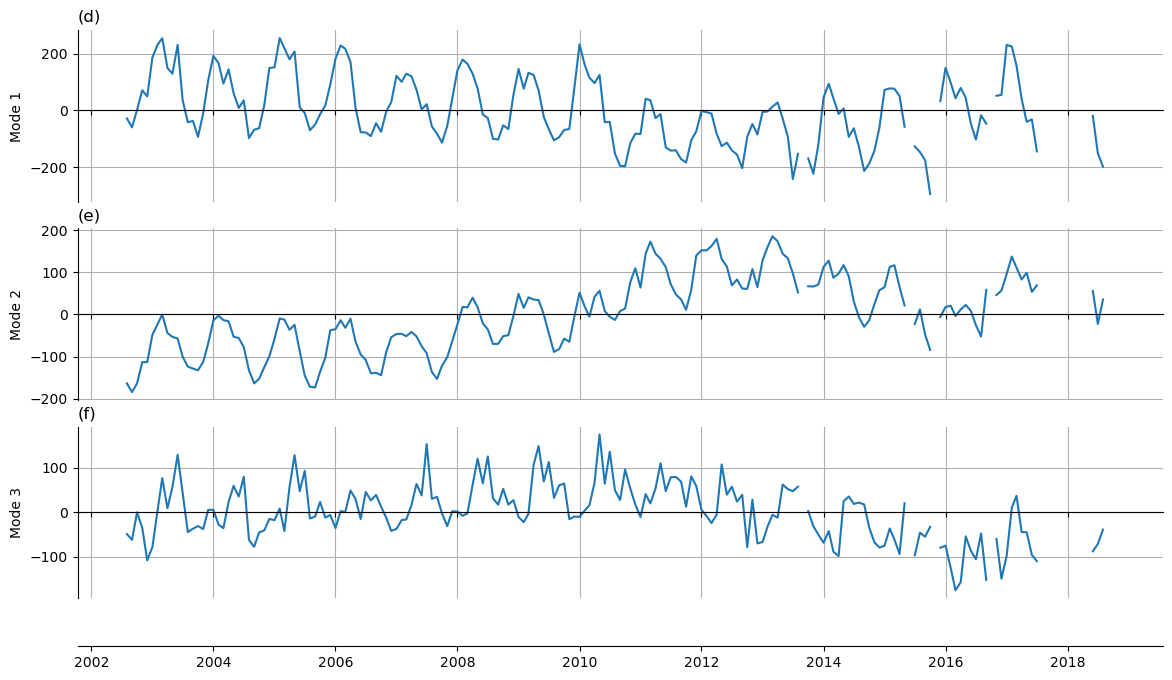

In [ ]:
scores = model.scores()
fig,ax = plt.subplots(4,1,figsize=(14,8),gridspec_kw={'height_ratios': [8,8,8,1]})
ax[0].plot(scores.time,scores.sel(mode=1))
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].grid(True)
ax[0].set_xticklabels([])
ax[0].spines['bottom'].set_position('zero')
ax[0].set_title('(d)',loc='left')
ax[0].set_ylabel('Mode 1')

plot_mode_ts(a)

ax[2].plot(scores.time,scores.sel(mode=3))
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['bottom'].set_position('zero')
ax[2].grid(True)
ax[2].set_xticklabels([])
ax[2].set_title('(f)',loc='left')
ax[2].set_ylabel('Mode 3')

ax[3].plot(scores.time,scores.sel(mode=2),alpha=0)
ax[3].spines['left'].set_visible(False)
ax[3].yaxis.set_visible(False)
ax[3].spines['top'].set_visible(False)
ax[3].spines['right'].set_visible(False)

